In [1]:
import os

datadir = '../data/XY-model/'
os.makedirs(datadir, exist_ok=True)

In [2]:
import netket as nk
from netket.graph import Lattice
from netket.operator.spin import sigmax, sigmay, sigmaz
import json
import jax.numpy as jnp
import numpy as np
def get_XYZ_Hamiltonian(Jxx, Jyy, Jzz, Lx, Ly):
    """
    Constructs the XYZ model Hamiltonian on a square lattice with periodic boundary conditions.

    H = -sum_{<i,j>} (Jxx S^x_i S^x_j + Jyy S^y_i S^y_j + Jzz S^z_i S^z_j)

    Args:
        Jxx: Coupling constant for x-direction
        Jyy: Coupling constant for y-direction
        Jzz: Coupling constant for z-direction
        Lx: Number of sites along x
        Ly: Number of sites along y

    Returns:
        g: NetKet Lattice object
        hi: NetKet Hilbert space
        H: NetKet Hamiltonian operator
    """
    g = Lattice(basis_vectors=[[1, 0], [0, 1]], pbc=True, extent=[Lx, Ly])
    hi = nk.hilbert.Spin(s=1/2, N=g.n_nodes)
    H = 0
    for (i,j) in g.edges():
        # Right neighbor
        H += -Jxx * sigmax(hi, i) * sigmax(hi, j) + Jyy * sigmay(hi, i) * sigmay(hi, j) + Jzz * sigmaz(hi, i) * sigmaz(hi, j)
    return g, hi, H

In [3]:
Lx = 4
Ly = 4
n_samples = 300
vmc_steps = 1000
learning_rate = 0.002
diag_shift = 1e-4
# diag_shift = 1e-1

In [4]:
g, hi, my_H = get_XYZ_Hamiltonian(1.0,1.0,0.0, Lx, Ly)
op = nk.optimizer.Sgd(learning_rate)
sr = nk.optimizer.SR(diag_shift=diag_shift, holomorphic=True)


eigenvalues, eigenvectors = nk.exact.lanczos_ed(my_H, k = 30, compute_eigenvectors = True)

print("Starting VMC...")

sa = nk.sampler.MetropolisLocal(hilbert = hi)
ma = nk.models.RBM(param_dtype=jnp.complex64, alpha = 1)
vs = nk.vqs.MCState(sa, ma, n_samples = n_samples * Lx * Ly)

# The ground-state optimization loop
gs = nk.VMC(hamiltonian = my_H, optimizer = op, preconditioner = sr, variational_state = vs)

gs.run(vmc_steps, out = datadir+"/vmc_xy", show_progress = True)

data_Jastrow = json.load(open(datadir+"/vmc_xy.log"))
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

np.savetxt(datadir+"/vmc_energy_xy.dat", np.column_stack((iters_Jastrow, energy_Jastrow)))

Starting VMC...


  0%|          | 0/1000 [00:00<?, ?it/s]

In [5]:
g, hi, my_H = get_XYZ_Hamiltonian(1.0,0.0,1.0, Lx, Ly)

print("Starting VMC...")

vs = nk.vqs.MCState(sa, ma, n_samples = n_samples * Lx * Ly)

# The ground-state optimization loop
gs = nk.VMC(hamiltonian = my_H, optimizer = op, preconditioner = sr, variational_state = vs)

gs.run(vmc_steps, out = datadir+"/vmc_xz", show_progress = True)

data_Jastrow = json.load(open(datadir+"/vmc_xz.log"))
iters_Jastrow = data_Jastrow["Energy"]["iters"]
energy_Jastrow = data_Jastrow["Energy"]["Mean"]["real"]

np.savetxt(datadir+"/vmc_energy_xz.dat", np.column_stack((iters_Jastrow, energy_Jastrow)))

Starting VMC...


  0%|          | 0/1000 [00:00<?, ?it/s]

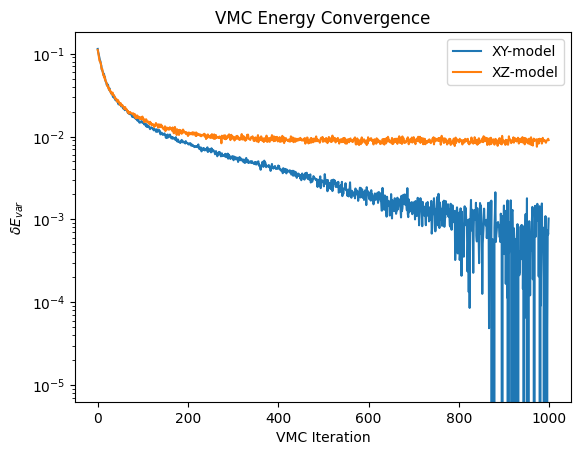

In [6]:
ed_energy = eigenvalues[0]

energy_data_xy = -(np.loadtxt(datadir+"/vmc_energy_xy.dat")[:,1] - ed_energy) / ed_energy
energy_data_xz = -(np.loadtxt(datadir+"/vmc_energy_xz.dat")[:,1] - ed_energy) / ed_energy

import matplotlib.pyplot as plt
plt.plot(energy_data_xy, label="XY-model")
plt.plot(energy_data_xz, label="XZ-model")
# plt.axhline(y = ed_energy, color = 'r', linestyle = '--', label="ED Ground State Energy")
plt.xlabel("VMC Iteration")
plt.ylabel(r"$\delta E_{var}$")
plt.title("VMC Energy Convergence")
plt.legend()
plt.yscale("log")


<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
<>:18: SyntaxWarning: invalid escape sequence '\d'
<>:21: SyntaxWarning: invalid escape sequence '\d'
/tmp/ipykernel_3110668/3266460026.py:18: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(range(len(psi_abs2_XZ[perm_XZ])), psi_abs2_XZ[perm_XZ], c='black', linewidth=1,label = f"XZ: $\delta E= {E_RBM_XZ:.4f}$")
/tmp/ipykernel_3110668/3266460026.py:21: SyntaxWarning: invalid escape sequence '\d'
  plt.plot(range(len(psi_abs2_XY[perm_XY])), psi_abs2_XY[perm_XY], c='black', linewidth=1,linestyle='--',label = f"XY: $\delta E= {E_RBM_XY:.4f}$")


Text(0.5, 1.0, 'Ground State Probability Distribution (colored by phase)')

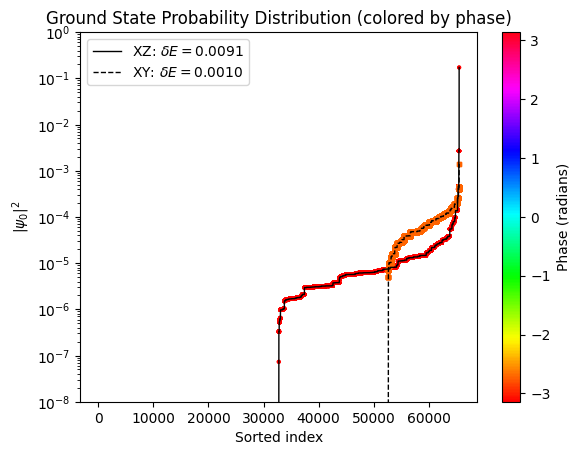

In [7]:
_,_, H_XY = get_XYZ_Hamiltonian(1.0,1.0,0.0, Lx, Ly)
_,_, H_XZ = get_XYZ_Hamiltonian(1.0,0.0,1.0, Lx, Ly)
E_RBM_XZ = energy_data_xz[-1]
E_RBM_XY = energy_data_xy[-1]

_, eigenvectors_XZ = nk.exact.lanczos_ed(H_XZ, k = 1, compute_eigenvectors = True)
_, eigenvectors_XY = nk.exact.lanczos_ed(H_XY, k = 1, compute_eigenvectors = True)

psi0_XZ = eigenvectors_XZ[:,0]
psi_abs2_XZ = jnp.abs(psi0_XZ)**2
perm_XZ = jnp.argsort(psi_abs2_XZ)

psi0_XY = eigenvectors_XY[:,0]
psi_abs2_XY = jnp.abs(psi0_XY)**2
perm_XY = jnp.argsort(psi_abs2_XY)

plt.scatter(range(len(psi_abs2_XZ[perm_XZ])), psi_abs2_XZ[perm_XZ], c=np.angle(psi0_XZ[perm_XZ]), cmap='hsv', s=4)
plt.plot(range(len(psi_abs2_XZ[perm_XZ])), psi_abs2_XZ[perm_XZ], c='black', linewidth=1,label = f"XZ: $\delta E= {E_RBM_XZ:.4f}$")

plt.scatter(range(len(psi_abs2_XY[perm_XY])), psi_abs2_XY[perm_XY], c=np.angle(psi0_XY[perm_XY]), cmap='hsv', marker='s', s=8)
plt.plot(range(len(psi_abs2_XY[perm_XY])), psi_abs2_XY[perm_XY], c='black', linewidth=1,linestyle='--',label = f"XY: $\delta E= {E_RBM_XY:.4f}$")
plt.colorbar(label="Phase (radians)")
plt.xlabel("Sorted index")
plt.ylabel(r"$|\psi_0|^2$")
plt.yscale("log")
plt.ylim(1e-8, 1)
plt.legend()
plt.title("Ground State Probability Distribution (colored by phase)")